# Introduction

In [1]:
#importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import random
from collections import defaultdict
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import copy


random.seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


# Data Loading and Analysis

In [2]:
img_dir = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/'
class_names = os.listdir(img_dir)
num_classes = len(class_names)

train_dir = '/kaggle/input/garbage-classification/one-indexed-files-notrash_train.txt'
test_dir = '/kaggle/input/garbage-classification/one-indexed-files-notrash_test.txt'
val_dir = '/kaggle/input/garbage-classification/one-indexed-files-notrash_val.txt'

df_train = pd.read_csv(train_dir, sep = ' ', header = None, names = ['path', 'label'])
df_test = pd.read_csv(test_dir, sep = ' ', header = None, names = ['path', 'label'])
df_val = pd.read_csv(val_dir, sep = ' ', header = None, names = ['path', 'label'])

print(f"Found {len(df_train)} training images, {len(df_test)} test images, {len(df_val)} validation images ")
print(f"Found {num_classes} classes: {class_names}")

Found 1768 training images, 431 test images, 328 validation images 
Found 6 classes: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [3]:
image_counts = {}

for class_name in class_names:
    class_path = os.path.join(img_dir, class_name)
    num_images = len(os.listdir(class_path))
    image_counts[class_name] = num_images
    print(f"Class: {class_name}, number of images: {num_images}")

Class: metal, number of images: 410
Class: glass, number of images: 501
Class: paper, number of images: 594
Class: trash, number of images: 137
Class: cardboard, number of images: 403
Class: plastic, number of images: 482


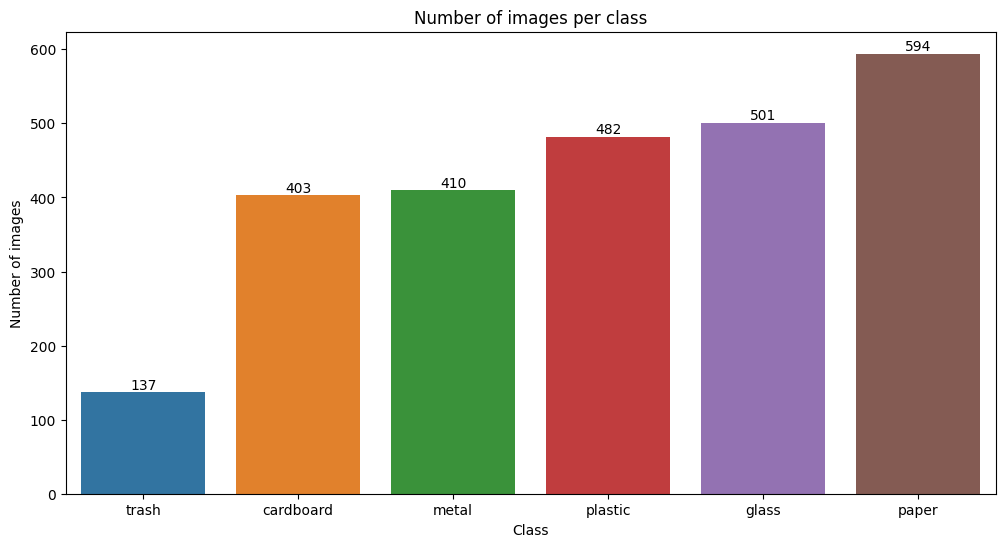

In [4]:
df_counts = pd.DataFrame(list(image_counts.items()), columns = ['Class', 'Count'])

plt.figure(figsize = (12,6))
ax = sns.barplot(x = 'Class', y = 'Count', data = df_counts.sort_values(by = 'Count'))
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.bar_label(ax.containers[0], fontsize=10)
plt.show()

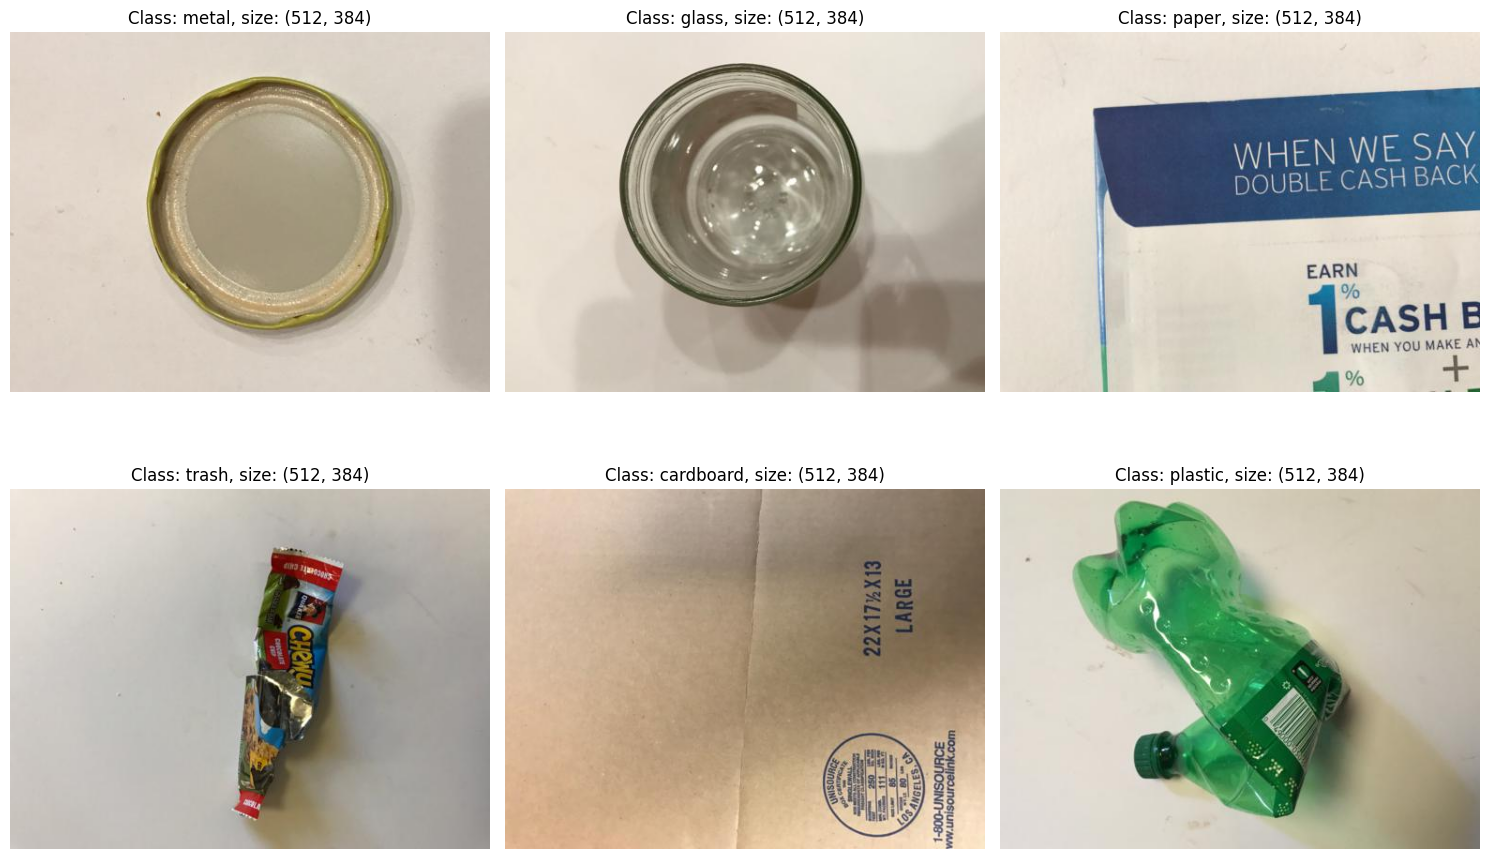

In [5]:
plt.figure(figsize = (15, 10))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(img_dir, class_name)
    random_image_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_image_name)
    plt.subplot(2, 3, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Class: {class_name}, size: {img.size}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
image_sizes = defaultdict(list)

for class_name in class_names:
    class_path = os.path.join(img_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            image_sizes['width'].append(width)
            image_sizes['height'].append(height)
df_sizes = pd.DataFrame(image_sizes)

In [7]:
df_sizes.describe()

,width,height
count,2527.0,2527.0
mean,512.0,384.0
std,0.0,0.0
min,512.0,384.0
25%,512.0,384.0
50%,512.0,384.0
75%,512.0,384.0
max,512.0,384.0


# Preprocessing

## Transformation

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalization parameters for resnet50
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalization parameters for resnet50
])

In [9]:
class_map = {
    1: 'glass',
    2: 'paper',
    3: 'cardboard',
    4: 'plastic',
    5: 'metal',
    6: 'trash'
}

class GarbageDataset(Dataset):
    def __init__(self, df, img_dir,transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        folder = class_map[int(row['label'])]
        filename = row['path']
        img_path = os.path.join(self.img_dir, folder, filename)
        image = Image.open(img_path)
        label = int(row['label']) - 1
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
train_dataset = GarbageDataset(df_train, img_dir, transform=train_transform)
val_dataset = GarbageDataset(df_val, img_dir, transform=test_val_transform)
test_dataset = GarbageDataset(df_test, img_dir, transform=test_val_transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [11]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


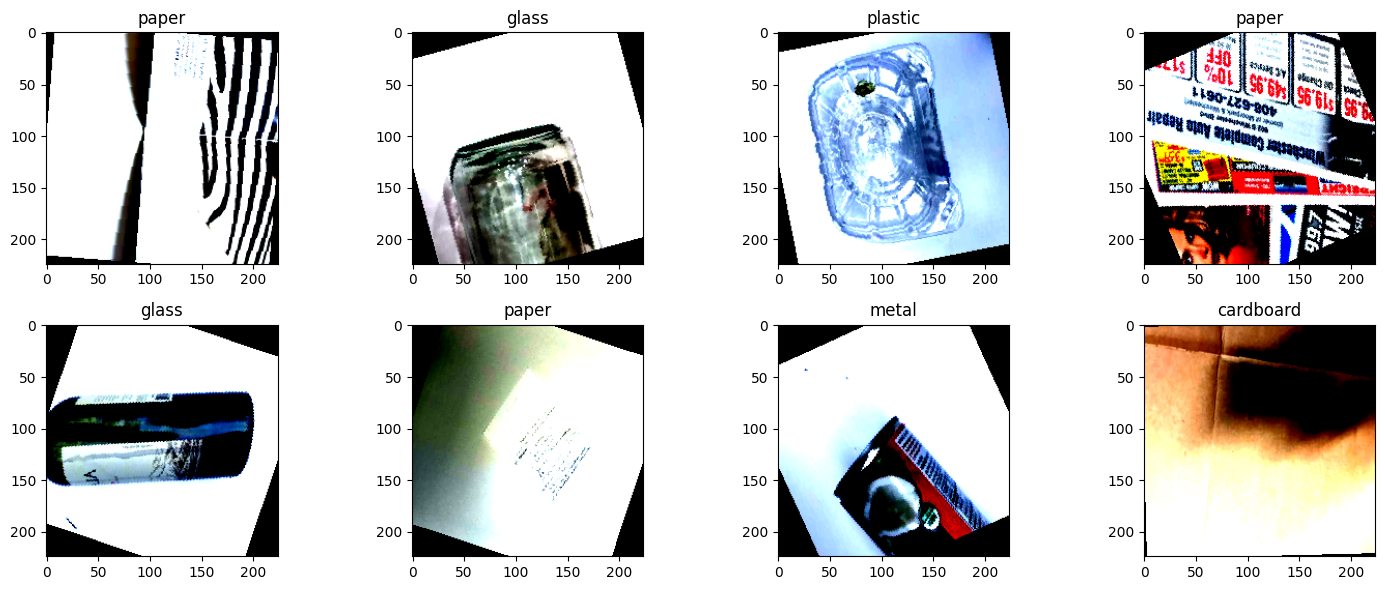

In [12]:
class_names = [class_map[i+1] for i in range(len(class_map))]
images, labels = next(iter(train_loader))
plt.figure(figsize=(15, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].numpy().transpose((1, 2, 0)))
    label_idx = labels[i].item()
    plt.title(class_names[label_idx])
plt.tight_layout()
plt.show()

# Custom CNN

In [13]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear (256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
customcnn = CustomCNN(num_classes=num_classes)

In [15]:
customcnn = customcnn.to(device)

# ResNet50

In [16]:
resnet50 = models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [17]:
#transfer learning - does not update weights in hidden layers
for param in resnet50.parameters():
    param.required_grad = False

In [18]:
num_features = resnet50.fc.in_features

In [19]:
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

In [20]:
resnet50 = resnet50.to(device)

In [21]:
df_counts

,Class,Count
0,metal,410
1,glass,501
2,paper,594
3,trash,137
4,cardboard,403
5,plastic,482


In [22]:
ordered_classes = [class_map[i] for i in range(1, num_classes + 1)]
df_counts_sorted = df_counts.set_index('Class').loc[ordered_classes].reset_index()
class_counts = df_counts_sorted['Count'].tolist()
print(class_counts)

[501, 594, 403, 482, 410, 137]


In [23]:
class_counts = torch.tensor(class_counts, dtype=torch.float32)

In [24]:
weights = class_counts.sum() / (len(class_counts) * class_counts)
weights = weights / weights.sum() * len(class_counts)
weights = weights.to(device)

In [25]:
criterion = nn.CrossEntropyLoss(weight=weights)

## Forward Pass Test

In [26]:
# testing forward pass of first batch
images, labels = next(iter(train_loader))
print("Input shape:", images.shape)
print("Labels shape:", labels.shape)

images = images.to(device)
labels = labels.to(device)

outputs = customcnn(images)
print("Output shape:", outputs.shape)

loss = criterion(outputs, labels)
print("Loss (first batch):", loss.item())

Input shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Output shape: torch.Size([32, 6])
Loss (first batch): 1.8148823976516724


# Training

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    best_model = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    #losses and accuracies for loss/acc plot
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*50)
        #training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() #Setting gradients to zero to avoid accumulation
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() #Perform a single optimization step to update parameter

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        #validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
        print(f'  Val loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            print("Best model updated.")

    print(f'Training complete. Best val accuracy: {best_val_acc:.4f}')
    model.load_state_dict(best_model)
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [28]:
num_epochs = 50
optimizer = optim.Adam(customcnn.parameters(), lr=0.001)

customcnn_model, customcnn_history = train_model(
    customcnn,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=num_epochs,
)

Epoch 1/50
--------------------------------------------------
Train loss: 6.3277, accuracy: 0.3450
  Val loss: 1.4720, accuracy: 0.3476
Best model updated.
Epoch 2/50
--------------------------------------------------
Train loss: 1.3293, accuracy: 0.4621
  Val loss: 1.4277, accuracy: 0.5061
Best model updated.
Epoch 3/50
--------------------------------------------------
Train loss: 1.3196, accuracy: 0.4740
  Val loss: 1.6728, accuracy: 0.4116
Epoch 4/50
--------------------------------------------------
Train loss: 1.2353, accuracy: 0.4977
  Val loss: 1.3898, accuracy: 0.5427
Best model updated.
Epoch 5/50
--------------------------------------------------
Train loss: 1.1485, accuracy: 0.5424
  Val loss: 1.4336, accuracy: 0.4878
Epoch 6/50
--------------------------------------------------
Train loss: 1.1022, accuracy: 0.5707
  Val loss: 1.3949, accuracy: 0.5305
Epoch 7/50
--------------------------------------------------
Train loss: 1.0729, accuracy: 0.5933
  Val loss: 1.4567, accur

In [29]:
num_epochs = 25
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

resnet50_model, resnet50_history = train_model(
    resnet50,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=num_epochs,
)

Epoch 1/25
--------------------------------------------------
Train loss: 1.3155, accuracy: 0.5215
  Val loss: 1.3114, accuracy: 0.5274
Best model updated.
Epoch 2/25
--------------------------------------------------
Train loss: 0.9421, accuracy: 0.6900
  Val loss: 1.0877, accuracy: 0.6189
Best model updated.
Epoch 3/25
--------------------------------------------------
Train loss: 0.7633, accuracy: 0.7217
  Val loss: 0.7991, accuracy: 0.7439
Best model updated.
Epoch 4/25
--------------------------------------------------
Train loss: 0.7490, accuracy: 0.7398
  Val loss: 0.7461, accuracy: 0.7774
Best model updated.
Epoch 5/25
--------------------------------------------------
Train loss: 0.5749, accuracy: 0.7998
  Val loss: 0.6914, accuracy: 0.7927
Best model updated.
Epoch 6/25
--------------------------------------------------
Train loss: 0.4690, accuracy: 0.8360
  Val loss: 0.7372, accuracy: 0.7622
Epoch 7/25
--------------------------------------------------
Train loss: 0.4655, ac

In [30]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score (all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)

    return {
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

In [31]:
def plot_loss_acc_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    #loss
    ax1.plot(history['train_losses'], label='Train Loss', color='blue')
    ax1.plot(history['val_losses'], label='Validation Loss', color='orange')
    ax1.set_title(f'{model_name} - Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_yticks(np.arange(0, 7, 0.5))
    ax1.legend()
    ax1.grid(True)

    #accuracy
    ax2.plot(history['train_accuracies'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', color='orange')
    ax2.set_title(f'{model_name} - Accuracy Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_yticks(np.arange(0, 1.1, 0.1))
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [32]:
customcnn_results = evaluate_model(customcnn_model, test_loader, device, class_names)
resnet_results = evaluate_model(resnet50_model, test_loader, device, class_names)

models_results = {
    'CustomCNN': customcnn_results,
    'ResNet50': resnet_results
}

<Figure size 400x400 with 0 Axes>

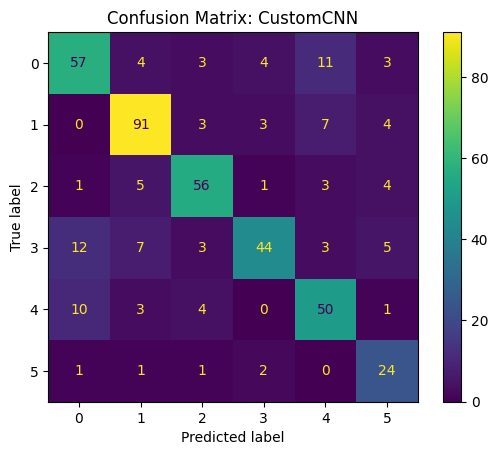

<Figure size 400x400 with 0 Axes>

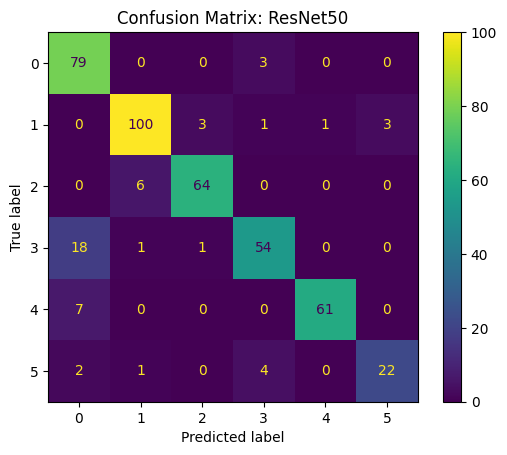

In [33]:
for model_name, results in models_results.items():
    cm = results['confusion_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(4, 4))
    disp.plot()
    plt.title(f'Confusion Matrix: {model_name}')
    plt.grid(False)
    plt.show()

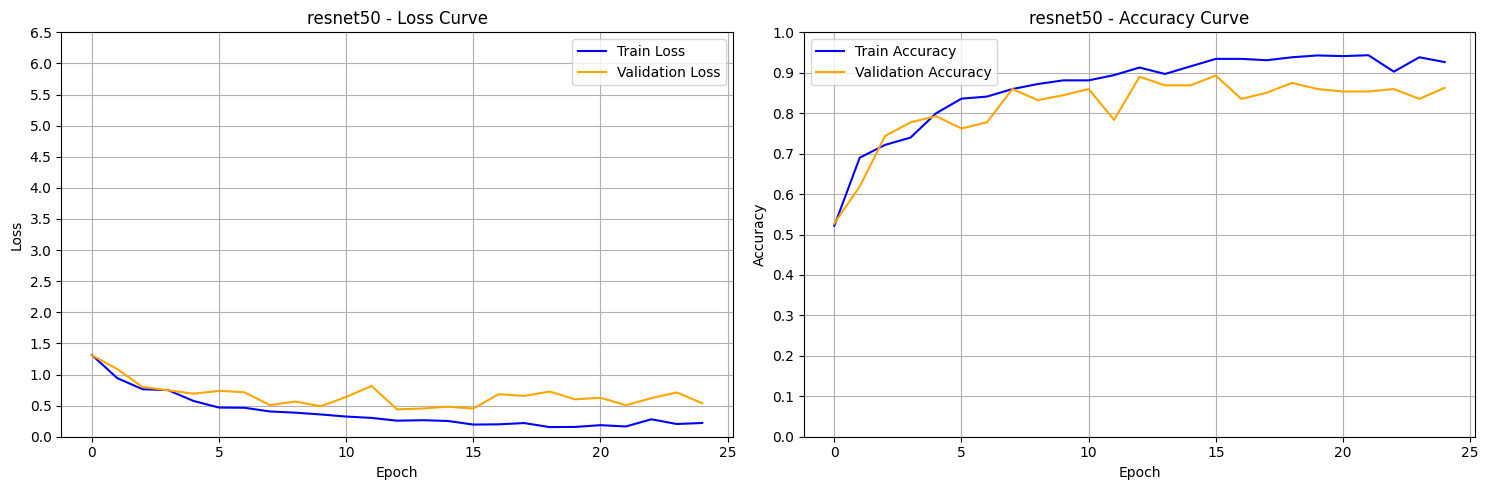

In [34]:
plot_loss_acc_curves(resnet50_history, 'resnet50')

    

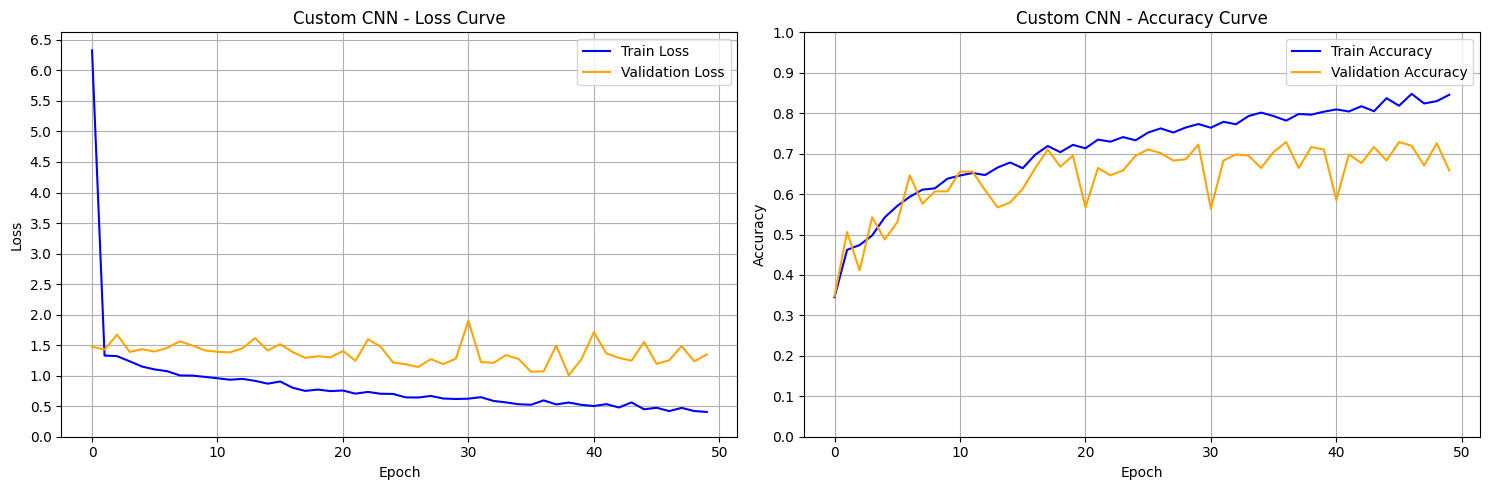

In [35]:
plot_loss_acc_curves(customcnn_history, 'Custom CNN')